## Activity 2: **MC for Taxi**

In [71]:
import numpy as np
import gymnasium as gym 
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [72]:
def train_mc_agent(config, n_episodes=10000, max_steps=100):

    env = gym.make('Taxi-v3')
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))
    
    gamma = config["gamma"]
    alpha = config["alpha"]
    decay_rate = config["decay_rate"]
    epsilon_min = config.get("epsilon_min", 0.01)
    epsilon_max = config.get("epsilon_max", 1.0)

    total_rewards = []

    def epsilon_greedy_policy(state, epsilon):
        if np.random.random() < epsilon:
            return env.action_space.sample()
        else:
            return np.argmax(Q[state])

    for episode in range(n_episodes):
        state, _ = env.reset()
        if config['decay_type'] == 'exponential':
            epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-decay_rate * episode)
        elif config['decay_type'] == 'linear':
            epsilon = max(epsilon_min, epsilon_max - (epsilon_max - epsilon_min) * (episode / n_episodes))


        episode_states = []
        episode_actions = []
        episode_rewards = []

        for step in range(max_steps):
            action = epsilon_greedy_policy(state, epsilon)
            next_state, reward, done, _, _ = env.step(action)

            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)

            if done:
                break

            state = next_state

        G = 0
        for t in range(len(episode_states) - 1, -1, -1):
            state = episode_states[t]
            action = episode_actions[t]
            G = gamma * G + episode_rewards[t]

            N[state, action] += 1
            Q[state, action] += alpha * (G - Q[state, action])

        total_rewards.append(sum(episode_rewards))
    
    avg_reward = np.mean(total_rewards[-1000:])

    print('Training Complete')

    return {
        "Q": Q,
        "rewards": total_rewards,
        "avg_reward": avg_reward,
        "config": config,
        "ε": epsilon,
        "env": env
    }

def evaluate_policy(Q, env, n_episodes=100, render=False, max_steps=200):
    total_rewards = []
    total_steps = []
    successful_episodes = 0

    for episode in range(n_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0
        steps = 0

        while not done and steps < max_steps:
            action = np.argmax(Q[state])
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            if render:
                env.render()

        if reward == 20:
            successful_episodes += 1

        total_rewards.append(episode_reward)
        total_steps.append(steps)

    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = successful_episodes / n_episodes

    print(f"Evaluation Results over {n_episodes} episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Steps to Finish: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate * 100:.2f}%")

def visualize_q_table_distribution(Q):
    max_q = np.max(Q, axis=1)
    plt.figure(figsize=(10, 4))
    sns.histplot(max_q, bins=50, kde=True)
    plt.title("Distribution of Max Q-values per State")
    plt.xlabel("Max Q(s,a)")
    plt.ylabel("Number of States")
    plt.grid()
    plt.show()

def action_to_symbol(action):
    return ['↓', '↑', '→', '←', 'p', 'd'][action]

def visualize_policy_grid(Q, env, passenger=0, destination=2):
    passenger_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)",
        4: "In Taxi"
    }
    destination_map = {
        0: "Red (R)",
        1: "Green (G)",
        2: "Yellow (Y)",
        3: "Blue (B)"
    }

    print(f"Taxi policy when passenger is at location {passenger_map[passenger]} and destination is {destination_map[destination]}")
    for row in range(5):
        line = ''
        for col in range(5):
            state = env.unwrapped.encode(row, col, passenger, destination)
            best_action = np.argmax(Q[state])
            symbol = action_to_symbol(best_action)
            line += symbol + ' '
        print(line)

### Training Loop (Linear decay)

In [73]:
config = {"gamma": 0.99, "alpha": 0.1, "decay_rate": 0.0005, 'decay_type': 'linear'}

result = train_mc_agent(config, 10000, 100)
print(f"Config: {config}")
print(f'Avg Reward: {result['avg_reward']} | ε: {result['ε']}')

Training Complete
Config: {'gamma': 0.99, 'alpha': 0.1, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Avg Reward: -16.638 | ε: 0.010098999999999969


### Evaluation

In [ ]:
evaluate_policy(result['Q'], result['env'], 100)

Evaluation Results over 100 episodes:
Avg Total Reward: -34.36
Avg Steps to Finish: 51.16
Success Rate: 80.00%


### Visualize Q Table

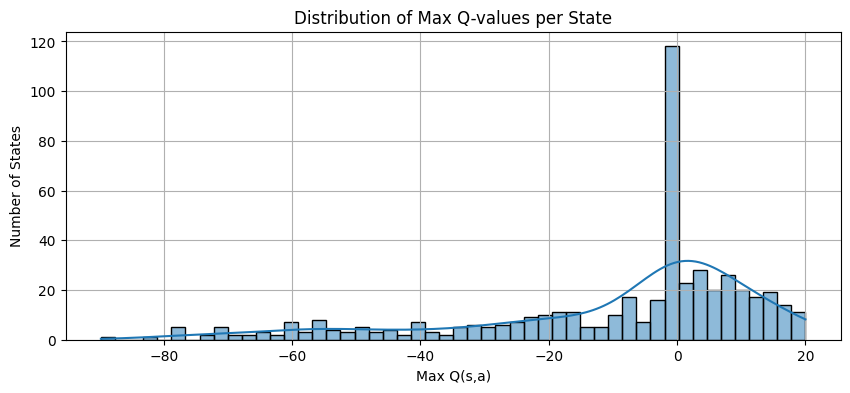

In [74]:
visualize_q_table_distribution(result['Q'])

### Policy Visualization (Dropoff & Pickup)

In [75]:
print("Visualizing grid before taxi pickup:")
visualize_policy_grid(result['Q'], result['env'], 0, 2)

print()

print("Visualizing grid after taxi pickup:")
visualize_policy_grid(result['Q'], result['env'], 4, 2)

Visualizing grid before taxi pickup:
Taxi policy when passenger is at location Red (R) and destination is Yellow (Y)
p ← ↓ ↓ ↓ 
↑ ← ↓ ← ↓ 
↑ ↑ ← ← ← 
↑ ↑ ← ↑ ↓ 
← ↑ → ← ↑ 

Visualizing grid after taxi pickup:
Taxi policy when passenger is at location In Taxi and destination is Yellow (Y)
↓ ↓ ← ↓ ← 
→ ↓ ↓ ← ← 
↓ ← ↓ ← ↓ 
↓ ↑ ← ↑ ← 
d ↑ ↑ → ↑ 


### Test & Compare Hyperparameters

In [48]:
test_configs = [
    {"gamma": 0.99, "alpha": 0.3, "decay_rate": 0.0005},
    {"gamma": 0.99, "alpha": 0.5, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.3, "decay_rate": 0.001},
    {"gamma": 1.0, "alpha": 0.5, "decay_rate": 0.0005},
]

results_list = []

for cfg in test_configs:
    for decay_type in ['linear', 'exponential']:
        cfg_copy = cfg.copy()
        cfg_copy['decay_type'] = decay_type
        result = train_mc_agent(cfg_copy)
        print(f"Config: {cfg_copy}")
        print(f'Avg Reward: {result['avg_reward']} | ε: {result['ε']}')
        results_list.append(result)

Training Complete
Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Avg Reward: -36.576 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.3, 'decay_rate': 0.0005, 'decay_type': 'exponential'}
Avg Reward: -36.576 | ε: 0.016673903646819088
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.5, 'decay_rate': 0.001, 'decay_type': 'linear'}
Avg Reward: -36.576 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 0.99, 'alpha': 0.5, 'decay_rate': 0.001, 'decay_type': 'exponential'}
Avg Reward: -36.576 | ε: 0.010044990898875783
Training Complete
Config: {'gamma': 1.0, 'alpha': 0.3, 'decay_rate': 0.001, 'decay_type': 'linear'}
Avg Reward: -36.576 | ε: 0.010098999999999969
Training Complete
Config: {'gamma': 1.0, 'alpha': 0.3, 'decay_rate': 0.001, 'decay_type': 'exponential'}
Avg Reward: -36.576 | ε: 0.010044990898875783
Training Complete
Config: {'gamma': 1.0, 'alpha': 0.5, 'decay_rate': 0.0005, 'decay_type': 'linear'}
Av

In [54]:
best_result = max(results_list, key = lambda x: x['avg_reward'])

print('Best Config:')
if best_result['config']['decay_type'] == 'exponential':
    print(f"Gamma: {best_result['config']['gamma']}")
    print(f"Alpha: {best_result['config']['alpha']}")
    print(f"Decay Rate: {best_result['config']['decay_rate']}")
    print(f"Decay Type: {best_result['config']['decay_type']}")
    print(f"Final ε: {best_result['ε']:.4f}")
    print(f"Avg Reward: {best_result['avg_reward']:.2f}")
else:
    print(f"Gamma: {best_result['config']['gamma']}")
    print(f"Alpha: {best_result['config']['alpha']}")
    print(f"Decay Type: {best_result['config']['decay_type']}")
    print(f"Final ε: {best_result['ε']:.4f}")
    print(f"Avg Reward: {best_result['avg_reward']:.2f}")

Best Config:
Gamma: 0.99
Alpha: 0.3
Decay Type: linear
Final ε: 0.0101
Avg Reward: -36.58


## Activity 2.3: **A SARSA agent in the Taxi Environment**

In [1]:
import gymnasium as gym
import numpy as np

In [2]:
# SARSA parameters
alpha = 0.05  # Learning rate
gamma = 0.9  # Discount factor

epsilon = 1.0     # starting epsilon  
epsilon_min = 0.03
epsilon_decay_rate = 0.9999 
episodes = 100000      # Number of episodes

In [6]:
env = gym.make('Taxi-v3')

height = 5
width = 5

Q = np.zeros((env.observation_space.n, env.action_space.n))

def epsilon_greedy_policy(state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state,:])
    

episode_reward = []

for episode in range(episodes):
    state, _ = env.reset()
    action = epsilon_greedy_policy(state, epsilon)
    done = False
    total_reward = 0
    while not done:
        
        next_state, reward, terminated, truncated, _= env.step(action)
        total_reward += reward
        next_action = epsilon_greedy_policy(next_state, epsilon)
        
        # SARSA update
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
        
        state = next_state
        action = next_action
        done = terminated

        if done:
            episode_reward.append(total_reward)
            if episode % 100 == 0:
                avg_reward = np.mean(episode_reward[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward}")

        
    if epsilon > epsilon_min:
        epsilon = max(epsilon_min, epsilon * epsilon_decay_rate)


Episode 0, Average Reward: -12026.0
Episode 100, Average Reward: -8813.36
Episode 200, Average Reward: -7399.89
Episode 300, Average Reward: -6056.05
Episode 400, Average Reward: -4775.46
Episode 500, Average Reward: -3447.23
Episode 600, Average Reward: -3091.57
Episode 700, Average Reward: -3239.11
Episode 800, Average Reward: -2448.83
Episode 900, Average Reward: -2809.42
Episode 1000, Average Reward: -2254.02
Episode 1100, Average Reward: -1920.67
Episode 1200, Average Reward: -1647.03
Episode 1300, Average Reward: -1733.74
Episode 1400, Average Reward: -1210.04
Episode 1500, Average Reward: -1667.99
Episode 1600, Average Reward: -1466.38
Episode 1700, Average Reward: -1196.42
Episode 1800, Average Reward: -1255.18
Episode 1900, Average Reward: -1008.92
Episode 2000, Average Reward: -1058.08
Episode 2100, Average Reward: -934.24
Episode 2200, Average Reward: -905.69
Episode 2300, Average Reward: -1028.82
Episode 2400, Average Reward: -1062.64
Episode 2500, Average Reward: -753.81
E

In [7]:
env = gym.make('Taxi-v3', render_mode = 'human')
max_steps = 100
n_test_episodes = 3
test_rewards = []
env.reset()
env.render()

for _ in range(n_test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    
    for _ in range(max_steps):
        action = np.argmax(Q[state])
        next_state, reward, done, _, _ = env.step(action)
        env.render()
        episode_reward += reward
        if done:
            break
        state = next_state
    
    test_rewards.append(episode_reward)

print(f"Average reward over {n_test_episodes} test episodes: {np.mean(test_rewards):.2f}")

KeyboardInterrupt: 